# 分類問題で使いそうな次元削減手法のまとめ #

## この記事の目的 ##
前回の記事ではirisの分類問題を解く一連の流れを書きましたが、今回はその中で特徴量の次元削減についてまとめました。記事の中では数個の手法で実際に特徴量を削減してirisの分類精度にどの程度影響するか確認してみました。特徴量の削減は、過学習の予防や計算効率の向上に役に立つので重要な行程ですので、ぜひ覚えておきたいテクニックです。

## 次元とは ##
機械学習における「次元」とは特徴量の数の事をいいます。例えば、身体測定の結果から性別を判別しようとしたら、身体測定の測定項目(身長、体重、視力、etc)の数が「次元」となります。

## 次元削減とは ##
次元削減とは、学習効率や精度を改善するために次元を削減する(特徴量を減らす)手法のことです。次元削減には様々な方法がありますが、今回は(初心者の僕の知識内で)一般的と思われる手法を試してみました。試した手法は以下のとおりです。並びの順序は特に意味はなく思いついた順番です。

1. PCA(主成分分析)による次元削減
2. LDA(線形判別分析)による次元削減・・・フィッシャーの線形判別
3. ランダムフォレスト
4. RFE・・・ロジスティック回帰で実験
5. 総当たり法・・・ロジスティック回帰で実験
6. 変数指定法
7. 相関係数
8. Forward Selection
9. Backward Selection

# 0. データ読み込み、データの前処理 #
ここではデータの読み込みからデータの分割までを行なっています。

In [1]:
from sklearn.datasets import load_iris
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

iris_data = load_iris()
iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df["target"] = iris_data.target

#学習用(&検証用)データとテスト用データを分ける
x_train, x_test, y_train, y_test = train_test_split(
    iris_df.iloc[:, 0:4],
    iris_df.iloc[:, 4],
    test_size = 0.3,
    random_state=1
)

#データの標準化
scl = StandardScaler()
scl.fit(x_train) #学習用データで標準化
x_train_std = scl.transform(x_train)
x_test_std = scl.transform(x_test)

# 1. PCAによる次元削減 #
PCA(Principal Component Analysis)は、データの分散が最大になるように新しい特徴量の軸を作成する、教師なし学習による次元削減手法です。これはデータの分散がデータ分類のための重要な情報であるという考えに基づいています。

### PCAの特徴 ###
- 教師なし学習
- 分散最大となる方向に次元軸を作成する。

In [2]:
from sklearn.decomposition import PCA
import numpy as np

pca=PCA()
pca.fit(x_train_std)
# display(pca.explained_variance_ratio_)
tot = sum(pca.explained_variance_ratio_)
print("寄与率:", str(["{:.1f}%".format(val * 100/tot)  for val in pca.explained_variance_ratio_]))

寄与率: ['72.2%', '23.5%', '4.0%', '0.4%']


寄与率をみると、上位２つで95%以上の寄与率となっているので、PCAでは２次元に圧縮したいと思います。scikit-learnに用意されているPCAを2次元(n_component=2)に指定して使用します。これによって、もともと４次元であった特徴量が、新しい２次元(pc1, pc2)の特徴量空間に圧縮されます。

データをpc1, pc2に射影した図


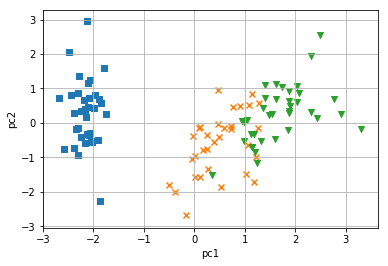

In [4]:
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
pca.fit(x_train_std)
# PCAによって２次元に圧縮された学習データ
x_train_pca = pca.transform(x_train_std)

# 圧縮された特徴量をグラフ化する
def show_scatter(x, y):
    markers = ["s", "x", "v"]
    for idx, label in enumerate(np.unique(y)):
        plt.scatter(
            x=x[y == label, 0], 
            y=x[y == label, 1],
            marker = markers[idx],
            label = label
        )
    plt.grid()
    plt.xlabel("pc1")
    plt.ylabel("pc2")
    plt.show()

print("データをpc1, pc2に射影した図")
show_scatter(x_train_pca, y_train)

### 参考 ###
- [Python機械学習プログラミング](https://book.impress.co.jp/books/1117101099)

# 2. LDAによる次元削減 #
LDA(Linear Discriminant Analysis)は、各クラスに分類しやすいような新しい特徴量の軸を作成する、教師あり学習による次元削減手法です。

### LDAの特徴 ###
- 教師あり学習
- 各クラスの共分散行列が等しい場合に使用できる

In [7]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit(x_train_std, y_train)
display(lda.explained_variance_ratio_)

array([0.98975884, 0.01024116])

寄与率をみると、１つの変数で99%となっているので、今回はこの１次元で十分なので１次元に圧縮します。

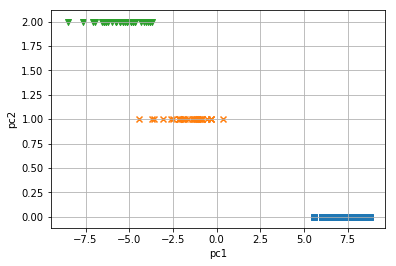

In [11]:
# 1次元でLDAのインスタンスを作成する
lda = LDA(n_components=1) 
lda.fit(x_train_std, y_train)
# 元データを新しい特徴量空間に射影
x_train_lda = lda.transform(x_train_std)

show_scatter(np.insert(x_train_lda, 1, y_train, axis=1), y_train)

### 参考 ###
- [Python機械学習プログラミング](https://book.impress.co.jp/books/1117101099)

# 3. ランダムフォレストによる次元削減 #

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(x_train_std, y_train)
print(rf.feature_importances_)

[0.26444549 0.04959946 0.37771205 0.30824301]


# 4. RFEによる次元削減 #
RFE(Recursive Feature Elimination)は

In [36]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1)
rfe = RFE(estimator=lr, n_features_to_select=1)
rfe.fit(x_train_std, y_train)
display(rfe.ranking_)

array([4, 3, 2, 1])

### 参考 ###
- [scikit-learn公式ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)
- [[機械学習]RFEを用いた特徴量の選別](https://qiita.com/nanairoGlasses/items/d7d4c190d11ba663635d)

# 6. 相関係数による次元削減 #
特徴量の中には似た特徴を表すものがあります。例えば、土地の幅と面積などがそうです。幅と面積それぞれ異なる特徴量ですが、面積は幅から計算できるため似た(相関の強い)情報になります。この様に相関の強いデータがあると、データの情報に偏りが生じて精度が悪くなる原因になります。そこで、相関の強いデータは削除します。

In [27]:
print(np.corrcoef(x_train_std.T))
display(iris_df.columns)

[[ 1.         -0.10002333  0.88718179  0.82263976]
 [-0.10002333  1.         -0.3612997  -0.29173819]
 [ 0.88718179 -0.3612997   1.          0.96370717]
 [ 0.82263976 -0.29173819  0.96370717  1.        ]]


Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')

# 7.  変数指定法 #
変数指定法は、分析したいデータの分野に関する専門知識(ドメイン知識)を使用して特徴量を選択します。要するに専門知識を利用した経験と勘で特徴量を選別します。

# 8. Forward Selection #
Forward Selection用の関数はscikit-learnには用意されていないようなので、自分で作成してみました。こんな感じになるのですかね...(= =?

# 9. Backward Selection #
Backward Selection用の関数はscikit-learnに用意されているのかにゃ？

# 8. 参考 #
- [特徴量選択のまとめ](https://qiita.com/shimopino/items/5fee7504c7acf044a521)
- [変数選択(Feature Selection)のまとめ](https://aotamasaki.hatenablog.com/entry/2018/04/18/201127#Forward-Selection)

# 9. 関連リンク #
- Qiitaの記事